# PyTorch Workflow

Let's explore an example PyTorch end-to-end workflow.

Resources:
* Ground truth notebook - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb
* Book version of notebook - https://www.learnpytorch.io/01_pytorch_workflow/
* Ask a question - https://github.com/mrdbourke/pytorch-deep-learning/discussions

In [1]:
what_where_covering = {1: "data (prepare and load)",
                       2: "build model",
                       3: "fitting the model to data (training)",
                       4: "making predictions and evaluating a model (inference)",
                       5: "saving a loading a model",
                       6: "putting it all together"}

what_where_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving a loading a model',
 6: 'putting it all together'}

In [2]:
import torch
from torch import nn  ## nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.3.0+cu121'

## 1. Data (preparing and loading)

Data can be almost anything... in machine learning.

* Excel speadsheet
* Images of any kind
* Videos (YouTube has lots of data...)
* Audio like songs or podcasts
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation

To showcase this, let`s create some *known* data using the linear regression formula.

We'll use a linear regression formula to make a straight line with *known* **parameters**.

In [3]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets (one of the most important concepts in machine learning in general)

Let's create a training and test set with our data.

In [5]:
# Create a train/test split
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

This is where the data explorer's motto comes in!

"Visualize, visualize, visualize!"

In [6]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Are there predictions?
  if predictions is not None:
    # Plot the predictions if they exists
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

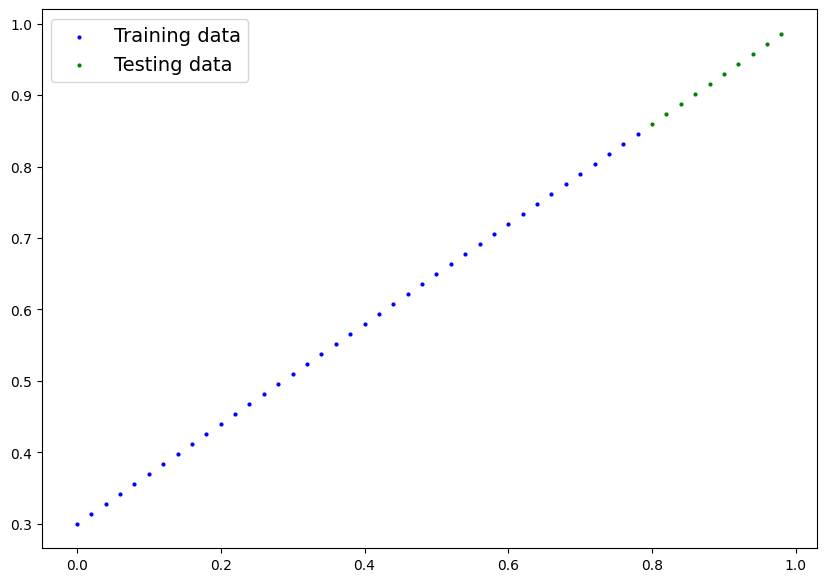

In [7]:
plot_predictions()

## 2. Build model

Our first PyTorch model!

This is very exciting... let's do it!

Because we're going to be building classes throughout the course, I'd recommend getting familiar with OOP in Python, to do so you can use the following resource from Real Python - https://realpython.com/python3-object-oriented-programming/

What our model does:
* Start with random values (weight and bias).
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data).

How does it do so?

Through two main algorithms:
* Gradient descent
* Backpropagation

In [8]:
from torch import nn

# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- Almost everything in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,  # <- start with a random weight and try to adjust ir to the ideal weight
                                            requires_grad=True, # <- can this parameter be updated via gradient descent?
                                            dtype=torch.float)) # <- PyTorch loves the datatype torch.float32
    self.bias = nn.Parameter(torch.randn(1, # <- start with a random bias and try to adjust it to the ideal bias
                                         requires_grad=True,  # <- can this parameter be updated via gradient descent?
                                         dtype=torch.float))  # <- PyTorch loves the datatype torch.float32b

  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights * x + self.bias # this is the linear regression formula

### PyTorch model building essentials

* torch.nn - Contains all of the buildings for computational graphs (a neural networks can be considered a computational graph)
* torch.nn.Parameter - What parameter should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural network models, if you subclass it, you should overwrite forward
* torch.optim - This is where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

See more of these essential modules via the PyTorch cheatsheet - https://pytorch.org/tutorials/beginner/ptcheat.html

### Checking the contents of our PyTorch model

Now we've created a model, let's see what's inside...

So we can checkout our model parameters or what's inside our model using `.parameters()`.

In [9]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Checkout the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# List name parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

To check out model's predictive power, let's see how well ir predicts `y_test` based on `X_test`.

When we pass data through our model, it's going to run it through the `forward()` method.

In [11]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

# You can also do something similar with torch.no_grad(), however, inference_mode() is preferred
# with torch.no_grad():
#   y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

See more on inference mode here - https://x.com/PyTorch/status/1437838231505096708?lang=es

In [12]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

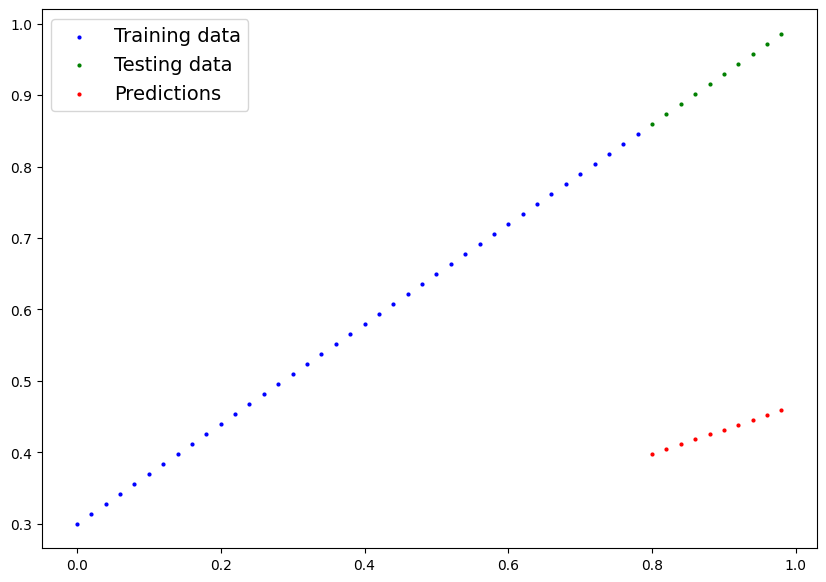

In [13]:
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters.

Or in other words from a poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong your models predictions are is to use a loss function.

* Note: Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer ro it as a loss function.

Things we need to train:

* **Loss function**: A function to measure how wrong your model's predictions are to the ideal outputs.
* **Optimizer**: Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias in our case) to improve the loss function - https://pytorch.org/docs/stable/optim.html#optimizer-step
  * Inside the optimizer you'll often have to set two parameters:
    * `params` - The model parameters you'd like to optimize, for example `params=model_0.parameters()`.
    * `lr` (learning rate) - The learning rate is a hyperparameter that defines how big/small the optimizer changes the parameters with each step (a small `lr` results in small changes, a large `lr` results in large changes).

And specifically for PyTorch, we need:

* A training loop.
* A testing loop.

In [14]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [15]:
# Check out our model's parameters (a paramter is a value that the model sets itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [16]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)  # lr = learning rate = possibily the most important hyperparameter you can set

**Q: Which loss function and optimizer should I use?**

**A:** This will br problem specific. But with experience, you'll get an idea of what works and what doesn't with your particular problem set.

For example, for a regression problem (like ours), a loss function of `nn.L1Loss()` and an optimizer like `torch.optim.SGD()` will suffice.

But for a classification problem like classifying whether a photo is of a dog or a cat, you'll likely want to use a loss function of `nn.BCELoss()` (binary cross entropy loss).

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass (this involves data moving through our model's `forward()`) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [53]:
# An epoch is one loop through the data... (this is a hyperparameter because we've set it ourselves)
epochs = 100

### Training
# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that requires gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)
  print(f"Loss: {loss}")

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step()  # by default how the optimizer changes will accumulate through the loop so... we have to zero them above in step 3 for the next iteration of the loop

  ### Testing
  model_0.eval()  # turns off gradient tracking

  # Print out model state_dict()
  print(model_0.state_dict())

Loss: 0.05845819041132927
OrderedDict([('weights', tensor([0.4425])), ('bias', tensor([0.3688]))])
Loss: 0.05635259300470352
OrderedDict([('weights', tensor([0.4455])), ('bias', tensor([0.3718]))])
Loss: 0.0545857772231102
OrderedDict([('weights', tensor([0.4483])), ('bias', tensor([0.3743]))])
Loss: 0.053148526698350906
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Loss: 0.05181945487856865
OrderedDict([('weights', tensor([0.4539])), ('bias', tensor([0.3788]))])
Loss: 0.05069301277399063
OrderedDict([('weights', tensor([0.4564])), ('bias', tensor([0.3803]))])
Loss: 0.0498228520154953
OrderedDict([('weights', tensor([0.4590])), ('bias', tensor([0.3818]))])
Loss: 0.04895269125699997
OrderedDict([('weights', tensor([0.4615])), ('bias', tensor([0.3833]))])
Loss: 0.04819351062178612
OrderedDict([('weights', tensor([0.4639])), ('bias', tensor([0.3843]))])
Loss: 0.047531817108392715
OrderedDict([('weights', tensor([0.4662])), ('bias', tensor([0.3853]))])
Loss: 0.04

In [54]:
weight, bias

(0.7, 0.3)

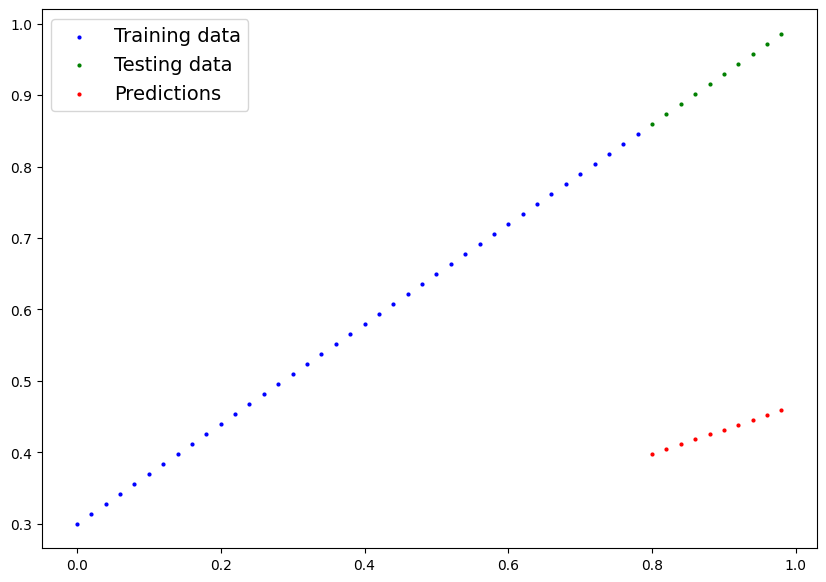

In [56]:
plot_predictions(predictions=y_preds)

In [57]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

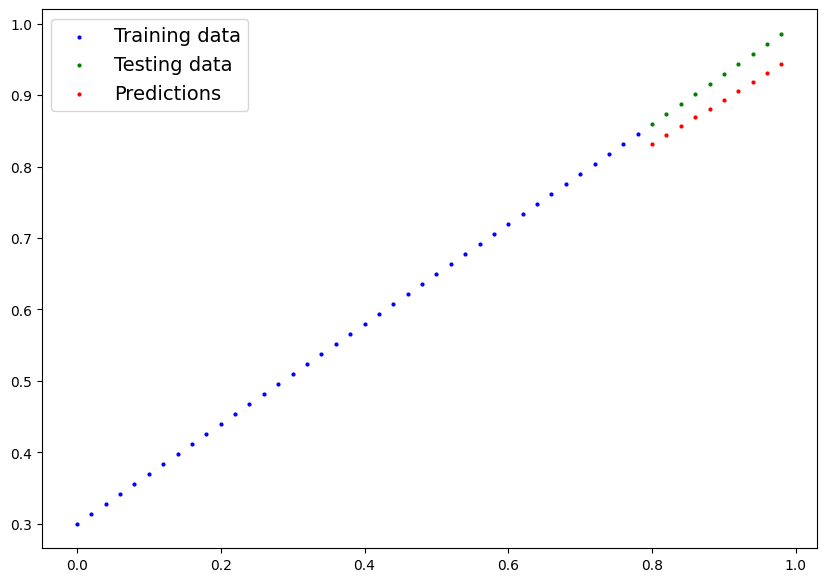

In [58]:
plot_predictions(predictions=y_preds_new)